In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

In [60]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [61]:
df = pd.read_csv('/content/curated_alerts_data.csv', index_col=False)
df['alert_summary_bug_number'] = df['alert_summary_bug_number'].apply(lambda x: int(x) if pd.notna(x) else x)

In [62]:
display(df.head(5))

,single_alert_new_value,single_alert_classifier,alert_summary_prev_push_revision,alert_summary_id,single_alert_amount_pct,alert_summary_performance_tags,single_alert_prev_value,alert_summary_first_triaged,single_alert_series_signature_has_subtests,alert_summary_framework,single_alert_series_signature_framework_id,single_alert_series_signature_suite_public_name,alert_summary_related_alerts,single_alert_taskcluster_metadata_retry_id,alert_summary_prev_push_id,alert_summary_status,alert_summary_push_id,single_alert_status,alert_summary_assignee_username,single_alert_series_signature_signature_hash,single_alert_prev_taskcluster_metadata_task_id,single_alert_series_signature_machine_platform,alert_summary_bug_number,alert_summary_repository,alert_summary_bug_due_date,single_alert_series_signature_test_public_name,alert_summary_issue_tracker,single_alert_amount_abs,single_alert_id,single_alert_series_signature_measurement_unit,single_alert_taskcluster_metadata_task_id,single_alert_backfill_record_total_backfills_successful,single_alert_summary_id,single_alert_series_signature_option_collection_hash,single_alert_prev_taskcluster_metadata_retry_id,single_alert_is_regression,single_alert_manually_created,single_alert_classifier_email,single_alert_backfill_record_total_backfills_failed,single_alert_backfill_record_total_actions_triggered,alert_summary_assignee_email,alert_summary_creation_timestamp,single_alert_prev_profile_url,alert_summary_notes,single_alert_series_signature_test,single_alert_noise_profile,single_alert_series_signature_lower_is_better,alert_summary_revision,single_alert_related_summary_id,alert_summary_bug_updated,single_alert_profile_url,single_alert_backfill_record_context,single_alert_starred,single_alert_backfill_record_total_backfills_in_progress,single_alert_t_value,single_alert_series_signature_suite,single_alert_series_signature_extra_options,single_alert_backfill_record_status,single_alert_series_signature_tags,alert_summary_triage_due_date,push_timestamp,signature_id
0,9.60,mozilla-ldap/nchevobbe@mozilla.com,702dc0aa87a8c3e4929277c1dc8220a7dd72418f,38845.0,4.71,NaN,10.08,2023-06-23 14:14:20.453894,False,12.0,12.0,NaN,|177677|,NaN,1261278.0,2.0,1261541.0,2.0,NaN,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-06-30 06:18:02.024736,NaN,1.0,-0.48,177750.0,ms,NaN,NaN,38845.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,False,False,nchevobbe@mozilla.com,NaN,NaN,NaN,2023-06-23 06:18:02.024736,NaN,NaN,custom.styleeditor.close.DAMP,OK,True,78880280c2765ec0520ece3184fc8fdbac5b5356,38852.0,NaN,NaN,NaN,False,NaN,9.06,damp,"e10s, fission, stylo, webrender",NaN,NaN,2023-06-28 06:18:02.024736,2023-06-21 20:43:57,4768977
1,10.58,mozilla-ldap/jdescottes@mozilla.com,25a29224e55d9a839d6fddde206208a453535ec8,39272.0,9.59,NaN,9.65,2023-08-14 08:38:03.490554,False,12.0,12.0,NaN,|179573|179581|,NaN,1284750.0,5.0,1285020.0,2.0,NaN,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-08-18 01:00:27.106098,NaN,1.0,0.93,179563.0,ms,NaN,NaN,39272.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,True,False,jdescottes@mozilla.com,NaN,NaN,NaN,2023-08-11 01:00:27.106098,NaN,NaN,custom.styleeditor.close.DAMP,OK,True,46b5603cd2b8de629b659ec8d44fc7b086782c46,39297.0,NaN,NaN,NaN,False,NaN,9.03,damp,"e10s, fission, stylo, webrender",NaN,NaN,2023-08-16 01:00:27.106098,2023-08-09 13:49:06,4768977
2,10.09,mozilla-ldap/jdescottes@mozilla.com,11f47f2a1cf08c1e0b5bb6374f2a7dd1f49c8cac,39287.0,5.54,NaN,10.68,2023-08-14 09:06:16.991824,False,12.0,12.0,NaN,|179664|179668|179670|179671|,NaN,1285701.0,6.0,1285800.0,4.0,mozilla-ldap/jdescottes@mozilla.com,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-08-21 14:07:14.457937,NaN,1.0,-0.59,179626.0,ms,NaN,NaN,39287.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,False,False,jdescottes@mozilla.com,NaN,NaN,jdescottes@mozilla.com,2023-08-12 14:07:14.457937,NaN,NaN,custom.styleeditor.close.DAMP,OK,T

In [63]:
print("Available measurement units for the measurement values triggering the alerts")
print(df['single_alert_series_signature_measurement_unit'].unique())

Available measurement units for the measurement values triggering the alerts
['ms' nan 'score' 'fps' 'bytes']


In [64]:
print("number of unique alerts")
print(df['single_alert_id'].nunique())
print("number of unique alert summaries")
print(df['alert_summary_id'].nunique())
print("number of unique signatures")
print(df['signature_id'].nunique())

number of unique alerts
17989
number of unique alert summaries
3912
number of unique signatures
5655


In [65]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_summary_creation_timestamp', 'alert_summary_first_triaged', 'alert_summary_triage_due_date', 'alert_summary_bug_due_date', 'alert_summary_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%d %H:%M:%S.%f')
df['push_timestamp'] = pd.to_datetime(df['push_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [66]:
# the mapping was concluded by comparing data from the dataset with data on Perfherder
alert_summary_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
# the framwork mapping was taken from the following API endpiint's response : https://treeherder.mozilla.org/docs/#tag/api/operation/listPerformanceFrameworks
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
# the mapping was concluded by comparing data from the dataset with data on Perfherder
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [67]:
df['alert_summary_framework'] = df['alert_summary_framework'].map(framework_mapping)
df['single_alert_status'] = df['single_alert_status'].astype(int).map(alert_status_mapping)
df['alert_summary_status'] = df['alert_summary_status'].astype(int).map(alert_summary_status_mapping)

We will conduct stats per alert summary

In [68]:
# for 5 alert summaries, the values of the the column alert_summary_notes were collected as integers for ome alerts and floats for other, and since eventually that column is a text, the different alerts of these 5 alert summaries were considered as if they belonged to different alert summaries (by counting unique rows of the alert summaries dataframe)
alert_summary_specific_columns = [col for col in df.columns if col.startswith('alert_summary_') and col != 'alert_summary_notes'] + ['push_timestamp']
df_alert_summaries = df[alert_summary_specific_columns].drop_duplicates()

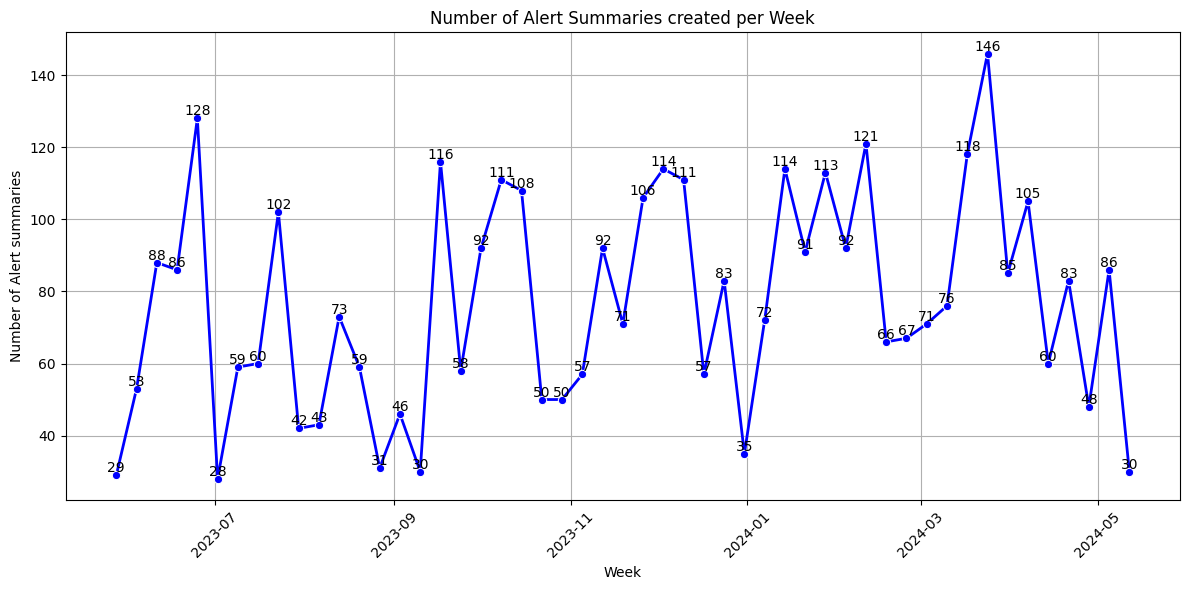

<Figure size 640x480 with 0 Axes>

In [69]:
dist_alert_summaries_df = df_alert_summaries.copy()
dist_alert_summaries_df.set_index('alert_summary_creation_timestamp', inplace=True)
weekly_entries = dist_alert_summaries_df.resample('W').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_entries.index, y=weekly_entries.values, marker='o', color='blue', linewidth=2)
plt.title('Number of Alert Summaries created per Week')
plt.xlabel('Week')
plt.ylabel('Number of Alert summaries')
plt.xticks(rotation=45)
plt.grid(True)
for i, value in enumerate(weekly_entries.values):
    plt.text(weekly_entries.index[i], value, str(value), ha='center', va='bottom')
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

In [70]:
project_distribution = df_alert_summaries['alert_summary_repository'].value_counts(normalize=True) * 100
display(project_distribution)

,proportion
alert_summary_repository,
autoland,84.841513
mozilla-beta,12.065440
firefox-android,3.016360
mozilla-central,0.051125
mozilla-release,0.025562


In [71]:
df[~df['alert_summary_repository'].isin(['autoland', 'mozilla-beta', 'firefox-android'])]

,single_alert_new_value,single_alert_classifier,alert_summary_prev_push_revision,alert_summary_id,single_alert_amount_pct,alert_summary_performance_tags,single_alert_prev_value,alert_summary_first_triaged,single_alert_series_signature_has_subtests,alert_summary_framework,single_alert_series_signature_framework_id,single_alert_series_signature_suite_public_name,alert_summary_related_alerts,single_alert_taskcluster_metadata_retry_id,alert_summary_prev_push_id,alert_summary_status,alert_summary_push_id,single_alert_status,alert_summary_assignee_username,single_alert_series_signature_signature_hash,single_alert_prev_taskcluster_metadata_task_id,single_alert_series_signature_machine_platform,alert_summary_bug_number,alert_summary_repository,alert_summary_bug_due_date,single_alert_series_signature_test_public_name,alert_summary_issue_tracker,single_alert_amount_abs,single_alert_id,single_alert_series_signature_measurement_unit,single_alert_taskcluster_metadata_task_id,single_alert_backfill_record_total_backfills_successful,single_alert_summary_id,single_alert_series_signature_option_collection_hash,single_alert_prev_taskcluster_metadata_retry_id,single_alert_is_regression,single_alert_manually_created,single_alert_classifier_email,single_alert_backfill_record_total_backfills_failed,single_alert_backfill_record_total_actions_triggered,alert_summary_assignee_email,alert_summary_creation_timestamp,single_alert_prev_profile_url,alert_summary_notes,single_alert_series_signature_test,single_alert_noise_profile,single_alert_series_signature_lower_is_better,alert_summary_revision,single_alert_related_summary_id,alert_summary_bug_updated,single_alert_profile_url,single_alert_backfill_record_context,single_alert_starred,single_alert_backfill_record_total_backfills_in_progress,single_alert_t_value,single_alert_series_signature_suite,single_alert_series_signature_extra_options,single_alert_backfill_record_status,single_alert_series_signature_tags,alert_summary_triage_due_date,push_timestamp,signature_id
17986,1121.00,mozilla-ldap/cpeterson@mozilla.com,86f79ebd25420a0bc1feadea488ca0b1c59771c6,34.0,34.87,NaN,831.17,2024-04-30 18:13:01.326485,False,mozperftest,15.0,NaN,NaN,0.0,1398622.0,wontfix,1399338.0,acknowledged,mozilla-ldap/cpeterson@mozilla.com,5f3934c495d062c92c5a3961e71875df65c40d27,a4qVL_LjSHOnbemHGgLJGw,android-hw-a51-11-0-aarch64-shippable,1894317.0,mozilla-central,2024-05-07 18:13:01.241232,NaN,1.0,289.83,79.0,ms,YrgqqI5jSomZ49cyL3-qIA,NaN,34.0,102210fe594ee9b33d82058545b1ed14f4c8206e,0.0,True,True,cpeterson@mozilla.com,NaN,NaN,cpeterson@mozilla.com,2024-04-30 18:13:01.241232,NaN,NaN,cold_main_first_frame.median,NaN,True,a93eeb987e4a1e533ac94ec0d1703c6f9b52b9ef,NaN,2024-04-30 18:19:33.557556,NaN,NaN,False,NaN,1000.00,AndroidStartup:fenix,NaN,NaN,NaN,2024-05-03 18:13:01.241232,2024-03-26 21:18:53,4677930
17987,2108.62,mozilla-ldap/cpeterson@mozilla.com,933dd3c3e1c8beb677df8e4d51b1e99b41599f65,38872.0,7.87,improvement,2288.79,2023-06-23 23:50:05.827016,False,mozperftest,15.0,NaN,NaN,NaN,1257505.0,improvement,1258418.0,acknowledged,mozilla-ldap/aglavic@mozilla.com,1686eae6b5138eb55d286e041bfe3ec985406e9e,NaN,android-hw-a51-11-0-aarch64-shippable,1831935.0,mozilla-central,2023-06-30 23:50:05.724081,NaN,1.0,-180.17,177805.0,ms,NaN,NaN,38872.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,False,True,cpeterson@mozilla.com,NaN,NaN,aglavic@mozilla.com,2023-06-23 23:50:05.724081,NaN,NaN,cold_view_nav_start.median,NaN,True,272d7188fe71c94facdcd15027c7b5385863315f,NaN,2023-06-23 23:50:24.161456,NaN,NaN,False,NaN,1000.00,AndroidStartup:geckoview_example,NaN,NaN,NaN,2023-06-28 23:50:05.724081,2023-06-15 21:43:34,4754836
17988,239.39,mozilla-ldap/afinder@mozilla.com,e757ad893b41c97a91f46c6f3910a90738b7acb1,39376.0,51.89,NaN,157.61,2023-08-29 12:59:20.556499,True,build_metrics,2.0,NaN,NaN,NaN,1289943.0,investigating,1290021.0,acknowledged,mozilla-ldap/afinder@mozilla.com,62d18e7178e5e49e8c418c03abac5bfcf7966f59,NaN,gecko-decision,1850519.0,mozilla-rel

In [72]:
def subtract_cols(dataf, resulting_column, first_column, second_column, day_stat=True):
    if day_stat:
        hour = 24
    else:
        hour = 1
    dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / (3600 * hour)
    dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
    dataf[resulting_column] = dataf[resulting_column].fillna(np.nan)
    dataf[resulting_column] = dataf[resulting_column].apply(lambda x: None if pd.isna(x) else int(x))

In [73]:
subtract_cols(df_alert_summaries, 'delta_push_to_alert_summary_creation', 'alert_summary_creation_timestamp', 'push_timestamp')
subtract_cols(df_alert_summaries, 'delta_alert_summary_creation_to_first_triage', 'alert_summary_first_triaged', 'alert_summary_creation_timestamp')
subtract_cols(df_alert_summaries, 'delta_alert_summary_creation_to_triage_duedate', 'alert_summary_triage_due_date', 'alert_summary_creation_timestamp')
subtract_cols(df_alert_summaries, 'delta_alert_summary_first_triaged_to_bug_due_date', 'alert_summary_bug_due_date', 'alert_summary_triage_due_date')

In [74]:
delta_columns = {'delta_push_to_alert_summary_creation': 'Time between commit push and creating its associated alert summary','delta_alert_summary_creation_to_first_triage': 'Time between creating an alert summary and its first triage (for applicable alerts only)','delta_alert_summary_creation_to_triage_duedate': 'Time between creating an alert summary and its triage duedate','delta_alert_summary_first_triaged_to_bug_due_date': 'Time between an alert summary first triage and creating its bug creation (for applicable alerts only)'}

In [75]:
def get_dist_of_cat(dataf, col, cat, cat_name):
  df_copy = dataf.copy()
  col_counts = df_copy[col].value_counts(normalize=True) * 100
  plt.figure(figsize=(10, 6))
  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')
  plt.title(f'Distribution of {cat_name} per {cat} Category (by percentage)')
  plt.xlabel(f'{cat}')
  plt.ylabel('Percentage')
  plt.show()

<ipython-input-75-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


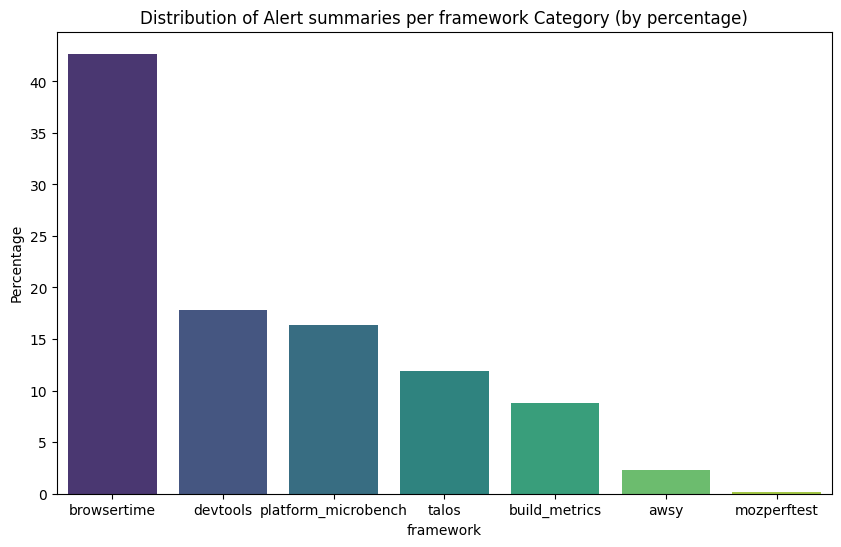

In [76]:
get_dist_of_cat(df_alert_summaries, 'alert_summary_framework', 'framework', 'Alert summaries')

<ipython-input-75-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


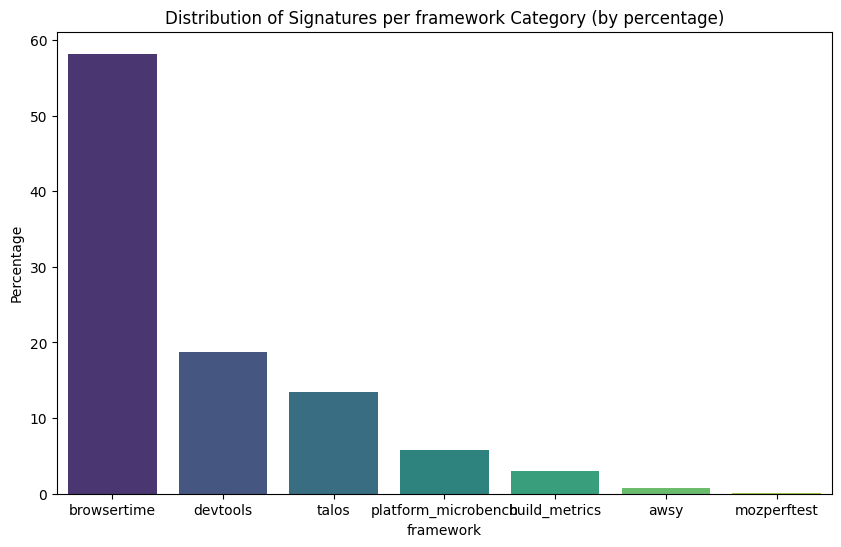

In [77]:
df_sig = df[['alert_summary_repository', 'alert_summary_framework', 'signature_id']].drop_duplicates()
get_dist_of_cat(df_sig, 'alert_summary_framework', 'framework', 'Signatures')

In [78]:
result_mean = df_alert_summaries.groupby('alert_summary_framework')[list(delta_columns.keys())].mean()
result_median = df_alert_summaries.groupby('alert_summary_framework')[list(delta_columns.keys())].median()
result_table = pd.concat([result_mean, result_median], axis=1, keys=['Mean', 'Median']).round(2)
display(result_table)

Mean  \
                        delta_push_to_alert_summary_creation   
alert_summary_framework                                        
awsy                                                    3.01   
browsertime                                             3.40   
build_metrics                                           1.95   
devtools                                                2.20   
mozperftest                                             8.67   
platform_microbench                                     1.96   
talos                                                   3.28   

                                                                      \
                        delta_alert_summary_creation_to_first_triage   
alert_summary_framework                                                
awsy                                                            0.47   
browsertime                                                     0.74   
build_metrics                                                   1.00   
devtools                                                        4.79   
mozperftest                                                    10.67   
platform_microbench                                             0.50   
talos                                                           1.01   

                                                                        \
                        delta_alert_summary_creation_to_triage_duedate   
alert_summary_framework                                                  
awsy                                                              4.08   
browsertime                                                       4.37   
build_metrics                                                     4.24   
devtools                                                          4.39   
mozperftest                                                       3.83   
platform_microbench                                               4.23   
talos                                                             4.19   

                                                                           \
                        delta_alert_summary_first_triaged_to_bug_due_date   
alert_summary_framework                                                     
awsy                                                                 3.11   
browsertime                                                          2.84   
build_metrics                                                        2.86   
devtools                                                             2.88   
mozperftest                                                          3.33   
platform_microbench                                                  2.91   
talos                                                                3.03   

                                                      Median  \
                        delta_push_to_alert_summary_creation   
alert_summary_framework                                        
awsy                                                     3.0   
browsertime                                              2.0   
build_metrics                                            1.0   
devtools                                                 2.0   
mozperftest                                              3.5   
platform_microbench                                      0.0   
talos                                                    2.0   

                                                                      \
                        delta_alert_summary_creation_to_first_triage   
alert_summary_framework                                                
awsy                                                             0.0   
browsertime                                                      0.0   
build_metrics                                                    0.0   
devtools                                                         3.0   
mozperftest                          

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_dist_by_perc_multiple_cols(dataf, col1, name_of_col1, col2, name_of_col2):
    # Bins and labels
    bins = [10, 20, 50, 100, float('inf')]
    labels = ['10-20', '21-50', '51-100', 'Above 100']

    # Process the first column
    dataf['grouped_1'] = dataf[col1].apply(
        lambda x: str(int(x)) if x <= 10 else pd.cut([x], bins=bins, labels=labels, right=True)[0]
    )

    # Process the second column
    dataf['grouped_2'] = dataf[col2].apply(
        lambda x: str(int(x)) if x <= 10 else pd.cut([x], bins=bins, labels=labels, right=True)[0]
    )

    # Calculate the percentage distribution of the grouped values for both columns
    value_counts_1 = dataf['grouped_1'].value_counts(normalize=True) * 100
    value_counts_2 = dataf['grouped_2'].value_counts(normalize=True) * 100

    # Reset the index to turn the index into a column
    value_counts_1 = value_counts_1.reset_index()
    value_counts_2 = value_counts_2.reset_index()

    # Rename the columns
    value_counts_1.columns = ['Category', f'{col1} Percentage']
    value_counts_2.columns = ['Category', f'{col2} Percentage']

    # Define the correct order of categories (1-10 first, followed by bins)
    sorted_values = [str(i) for i in range(1, 11)] + labels

    # Filter out the bins that are not present in the data
    sorted_values_1 = [v for v in sorted_values if v in value_counts_1['Category'].values]
    sorted_values_2 = [v for v in sorted_values if v in value_counts_2['Category'].values]

    # Plot the distribution using the sorted values
    plt.figure(figsize=(12, 6))

    # Create two bars: one for col1 and one for col2
    sns.barplot(x=value_counts_1.set_index('Category').reindex(sorted_values_1).index,
                y=value_counts_1.set_index('Category').reindex(sorted_values_1)[f'{col1} Percentage'].values,
                color='blue', alpha=0.6, label=name_of_col1)

    sns.barplot(x=value_counts_2.set_index('Category').reindex(sorted_values_2).index,
                y=value_counts_2.set_index('Category').reindex(sorted_values_2)[f'{col2} Percentage'].values,
                color='orange', alpha=0.6, label=name_of_col2)

    # Set custom x-axis labels (e.g., ">=1", ">=2", ..., ">=9")
    new_labels = [f">={i}" for i in range(1, 10)] + labels
    plt.xticks(ticks=range(len(value_counts_1.set_index('Category').reindex(sorted_values_1).index)),
               labels=new_labels[:len(value_counts_1.set_index('Category').reindex(sorted_values_1).index)],
               rotation=45)

    # Title and labels
    plt.title(f'Distribution of {name_of_col1} and {name_of_col2} in percentage')
    plt.ylabel('Percentage')
    plt.xlabel('Number of days')

    # Place the legend box inside the graph, in the upper right corner
    plt.legend(title='Columns', loc='upper right')

    # Show the plot
    plt.show()


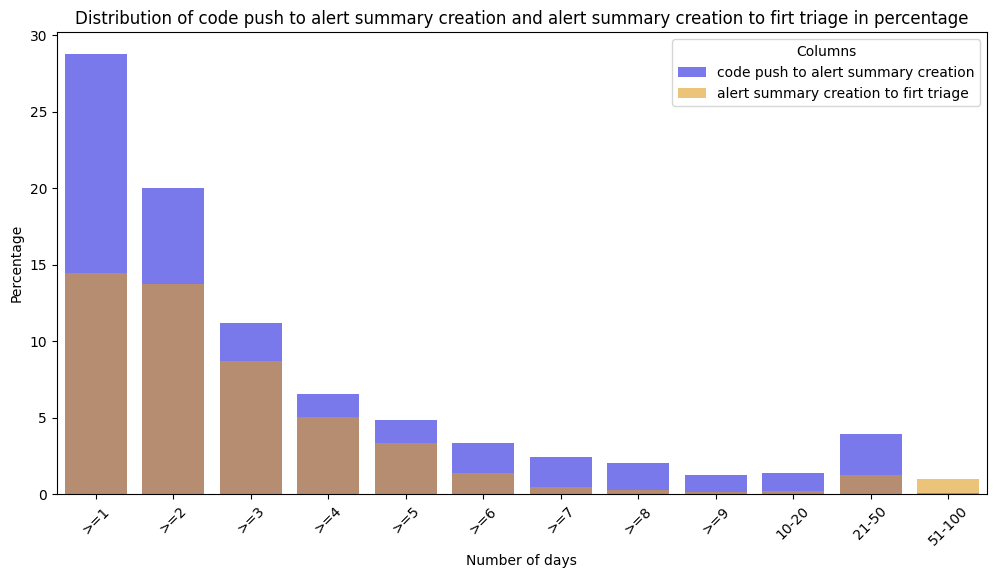

In [80]:
get_dist_by_perc_multiple_cols(df_alert_summaries, 'delta_push_to_alert_summary_creation', 'code push to alert summary creation', 'delta_alert_summary_creation_to_first_triage', 'alert summary creation to firt triage')

In [81]:
def get_dist_by_perc(dataf, cols):
    bins = [10, 20, 50, 100, float('inf')]
    labels = ['10-20', '21-50', '51-100', 'Above 100']

    for col in cols:
        dataf['grouped'] = dataf[col].apply(
            lambda x: str(int(x)) if x <= 10 else pd.cut([x], bins=bins, labels=labels, right=True)[0]
        )

        # Calculate the percentage distribution of the grouped values
        value_counts = dataf['grouped'].value_counts(normalize=True) * 100

        # Define the correct order of categories (1-10 first, followed by bins)
        sorted_values = [str(i) for i in range(1, 11)] + labels

        # Filter out the bins that are not present in the data
        sorted_values = [v for v in sorted_values if v in value_counts.index]

        # Plot the distribution using the sorted values
        plt.figure(figsize=(10, 6))
        sns.barplot(x=value_counts[sorted_values].index, y=value_counts[sorted_values].values)

        # Set custom x-axis labels (e.g., ">=1", ">=2", ..., ">=9")
        new_labels = [f">={i}" for i in range(1, 10)] + labels
        plt.xticks(ticks=range(len(value_counts[sorted_values].index)), labels=new_labels[:len(value_counts[sorted_values].index)], rotation=45)

        # Title and labels
        plt.title(f'Distribution of {col} in percentage')
        plt.ylabel('Percentage')
        plt.xlabel(f'{col}')

        # Create the table below the graph
        table_data = value_counts[sorted_values].reset_index()
        table_data.columns = ['Category', 'Percentage']

        # Position the table below the graph
        table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center', bbox=[0, -0.3, 1, 0.2])
        table.auto_set_font_size(False)
        table.set_fontsize(10)

        # Show the plot and table
        plt.show()


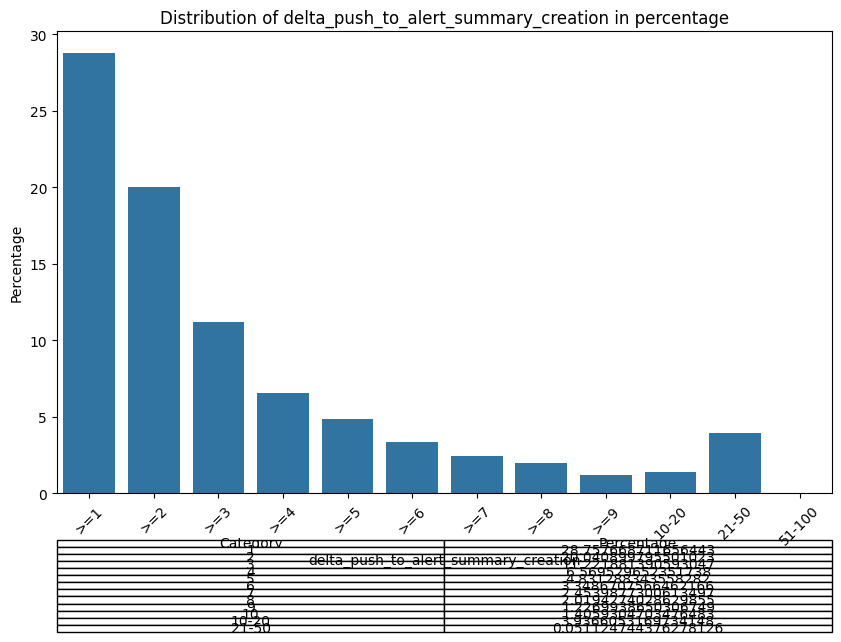

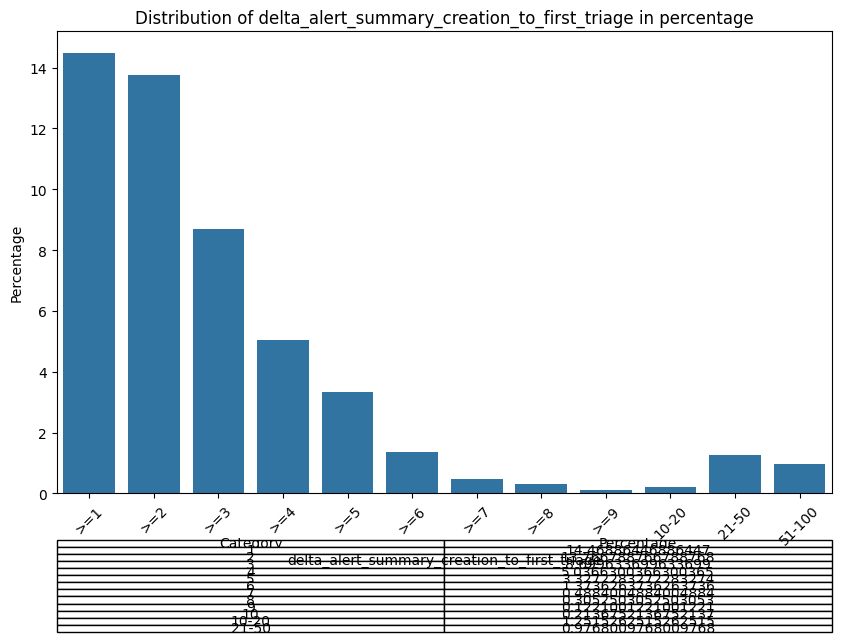

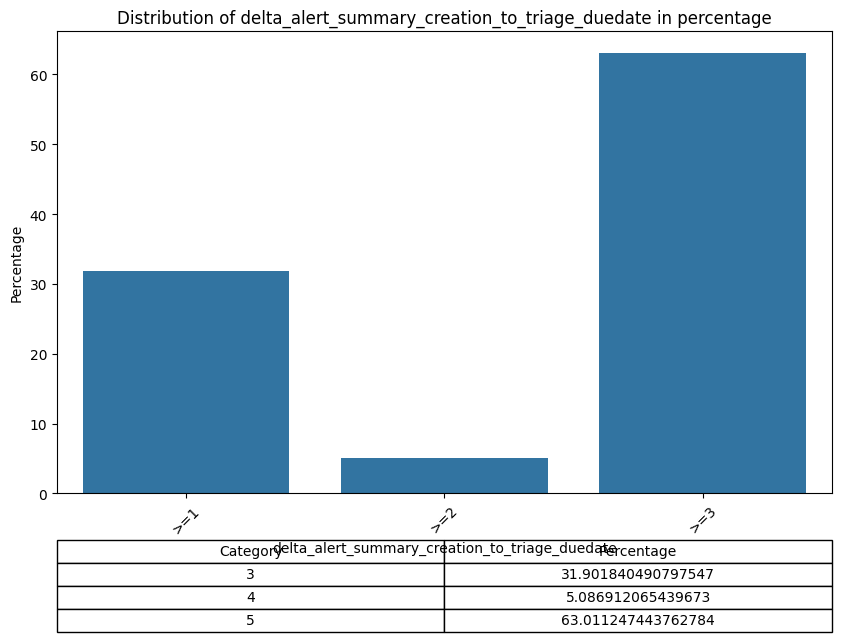

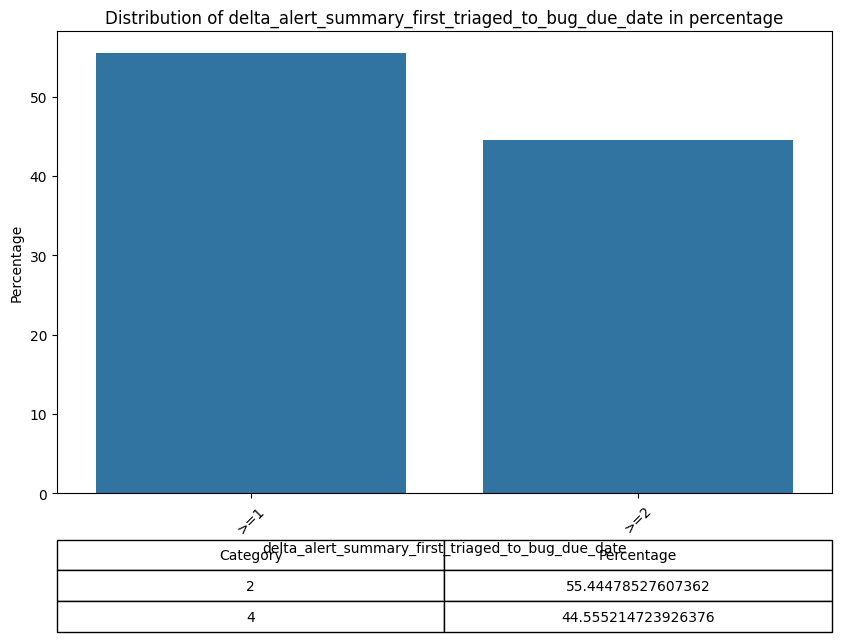

In [82]:
get_dist_by_perc(df_alert_summaries, delta_columns)

In [83]:
def count_and_percentage_na(dataf, first_column, second_column):
    count_first_notna_second_na = dataf[first_column].notna() & dataf[second_column].isna()
    count_first_notna_second_na = count_first_notna_second_na.sum()
    count_second_notna_first_na = dataf[second_column].notna() & dataf[first_column].isna()
    count_second_notna_first_na = count_second_notna_first_na.sum()
    total_rows = len(dataf)
    percent_first_notna_second_na = (count_first_notna_second_na / total_rows) * 100
    percent_second_notna_first_na = (count_second_notna_first_na / total_rows) * 100
    print(f"Rows where '{first_column}' is not NaN and '{second_column}' is NaN: {count_first_notna_second_na} rows ({percent_first_notna_second_na:.2f}%)")
    print(f"Rows where '{second_column}' is not NaN and '{first_column}' is NaN: {count_second_notna_first_na} rows ({percent_second_notna_first_na:.2f}%)")

In [84]:
count_and_percentage_na(df_alert_summaries, 'alert_summary_creation_timestamp', 'push_timestamp')
count_and_percentage_na(df_alert_summaries, 'alert_summary_first_triaged', 'alert_summary_creation_timestamp')
count_and_percentage_na(df_alert_summaries, 'alert_summary_triage_due_date', 'alert_summary_creation_timestamp')
count_and_percentage_na(df_alert_summaries, 'alert_summary_bug_due_date', 'alert_summary_first_triaged')

Rows where 'alert_summary_creation_timestamp' is not NaN and 'push_timestamp' is NaN: 0 rows (0.00%)
Rows where 'push_timestamp' is not NaN and 'alert_summary_creation_timestamp' is NaN: 0 rows (0.00%)
Rows where 'alert_summary_first_triaged' is not NaN and 'alert_summary_creation_timestamp' is NaN: 0 rows (0.00%)
Rows where 'alert_summary_creation_timestamp' is not NaN and 'alert_summary_first_triaged' is NaN: 636 rows (16.26%)
Rows where 'alert_summary_triage_due_date' is not NaN and 'alert_summary_creation_timestamp' is NaN: 0 rows (0.00%)
Rows where 'alert_summary_creation_timestamp' is not NaN and 'alert_summary_triage_due_date' is NaN: 0 rows (0.00%)
Rows where 'alert_summary_bug_due_date' is not NaN and 'alert_summary_first_triaged' is NaN: 636 rows (16.26%)
Rows where 'alert_summary_first_triaged' is not NaN and 'alert_summary_bug_due_date' is NaN: 0 rows (0.00%)


This means that 16.26% of the 3912 alert summaries haven't been triaged

In [85]:
print(df_alert_summaries['alert_summary_bug_number'].nunique())

482


In [86]:
print(df_alert_summaries['alert_summary_bug_number'].notna().sum())
print(df_alert_summaries['alert_summary_bug_number'].notna().sum() / len(df_alert_summaries) * 100)

633
16.180981595092025


In [87]:
print

<function print>

## Analysis of TP6/Speedometer3 signatures

In [88]:
speedometer3_signatures = df[df['single_alert_series_signature_suite'] == 'speedometer3']['signature_id'].unique().tolist()
desktop_list = ["amazon", "bing-search", "buzzfeed", "cnn", "docomo", "ebay", "espn", "expedia", "facebook", "fandom", "google-docs", "google-mail", "google-search", "google-slides", "imdb", "imgue", "instagram", "linkedin", "microsoft", "netflix", "nytimes", "office", "openai", "outlook", "paypal", "pinterest", "reddit", "samsung", "tiktok", "tumblr", "twitch", "twitter", "weather", "wikia", "wikipedia", "yahoo-mail", "youtube"]
mobile_list = ["allrecipes", "amazon", "amazon-search", "bild-de", "bing", "bing-search-restaurants", "booking", "cnn", "cnn-ampstories", "dailymail", "ebay-kleinanzeigen", "ebay-kleinanzeigen-search", "espn", "facebook", "facebook-cristiano", "google", "google-maps", "google-search-restaurants", "imdb", "instagram", "microsoft-support", "reddit", "sina", "stackoverflow", "wikipedia", "youtube", "youtube-watch"]
tp6_suites_list = list(set(desktop_list + mobile_list))
tp6_signatures = df[df['single_alert_series_signature_suite'].isin(tp6_suites_list)]['signature_id'].unique().tolist()
speedometer3_tp6_signatures = speedometer3_signatures + tp6_signatures

In [89]:
print('number of Speedometer3 signatures')
print(len(speedometer3_signatures))
print('number of TP6 signatures')
print(len(tp6_signatures))
print('number of Speedometer3/TP6 signatures')
print(len(speedometer3_tp6_signatures))

number of Speedometer3 signatures
10
number of TP6 signatures
2908
number of Speedometer3/TP6 signatures
2918


In [90]:
speedometer3_tp6_df = df[df['signature_id'].isin(speedometer3_tp6_signatures)]

In [91]:
print('number of Speedometer3/TP6 alerts')
print(len(speedometer3_tp6_df))

number of Speedometer3/TP6 alerts
8788


In [92]:
category_mapping = {
        'investigating': 'SP',
        'reassigned': 'TP',
        'invalid': 'FP',
        'improvement': 'TP',
        'fixed': 'TP',
        'wontfix': 'TP',
        'untriaged': 'SP',
        'backedout': 'TP',
        'downstream': 'TP'
    }

In [93]:
df['alert_status_general'] = df['alert_summary_status'].map(category_mapping)
df.loc[df['single_alert_manually_created'] == True, 'alert_status_general'] = 'FN'
alert_summary_status_distribution_alerts_df = df['alert_status_general'].value_counts(normalize=True) * 100
print('Distributions of alert summaries statuses')
display(alert_summary_status_distribution_alerts_df)

Distributions of alert summaries statuses


,proportion
alert_status_general,
TP,56.673523
SP,37.044861
FP,4.702874
FN,1.578743


In [94]:
df_alert_summaries['alert_status_general'] = df_alert_summaries['alert_summary_status'].map(category_mapping)
alert_summary_status_distribution = df_alert_summaries['alert_status_general'].value_counts(normalize=True) * 100
print('Distributions of alert summaries statuses')
display(alert_summary_status_distribution)

Distributions of alert summaries statuses


,proportion
alert_status_general,
TP,56.313906
SP,31.211656
FP,12.474438


In [95]:
bug_counts = df.dropna(subset=['alert_summary_bug_number']).groupby('alert_summary_bug_number')
display(bug_counts)
# if (bug_counts > 1).any():
#     raise ValueError("Error: Some bugs are associated with multiple projects.")

# Group by alert_summary_repository and compute stats
repository_stats = df.groupby('alert_summary_repository').agg(
    alerts=('single_alert_id', 'count'),
    unique_signatures=('signature_id', 'nunique'),
    unique_summaries=('alert_summary_id', 'nunique'),
    unique_bugs=('alert_summary_bug_number', lambda x: x.dropna().nunique())  # Count unique bugs
)

# Add a "total" row for all repositories
repository_stats.loc['Total'] = repository_stats.sum(numeric_only=True)

# Display the result
display(repository_stats)

,alerts,unique_signatures,unique_summaries,unique_bugs
alert_summary_repository,,,,
autoland,13593,3833,3319,438
firefox-android,796,342,118,25
mozilla-beta,3597,1477,472,25
mozilla-central,2,2,2,2
mozilla-release,1,1,1,1
Total,17989,5655,3912,491


In [96]:
print(df['alert_summary_bug_number'].nunique())

482


The number of total unique bugs in total are 482 but per project it is 491. This is because sme bugs are linked to isue that propagated throughout multiple repositories (7 bug propated through 2 trepositories and 1 bug propagated over 3)

In [97]:
bugs_multiple_repos = df.groupby('alert_summary_bug_number')['alert_summary_repository'].nunique()
bugs_multiple_repos = bugs_multiple_repos[bugs_multiple_repos > 1].index
df_multiple_repos = df[df['alert_summary_bug_number'].isin(bugs_multiple_repos)]
display(df_multiple_repos[['alert_summary_bug_number','alert_summary_repository']].drop_duplicates())

,alert_summary_bug_number,alert_summary_repository
469,1854045.0,autoland
1144,1859427.0,autoland
1242,1857618.0,autoland
2951,1746524.0,autoland
4143,1836369.0,autoland
5108,1862583.0,autoland
9154,1831935.0,autoland
13337,1842437.0,autoland
13611,1857618.0,firefox-android
14368,1836369.0,firefox-android


In [98]:
display(df.head(5))

,single_alert_new_value,single_alert_classifier,alert_summary_prev_push_revision,alert_summary_id,single_alert_amount_pct,alert_summary_performance_tags,single_alert_prev_value,alert_summary_first_triaged,single_alert_series_signature_has_subtests,alert_summary_framework,single_alert_series_signature_framework_id,single_alert_series_signature_suite_public_name,alert_summary_related_alerts,single_alert_taskcluster_metadata_retry_id,alert_summary_prev_push_id,alert_summary_status,alert_summary_push_id,single_alert_status,alert_summary_assignee_username,single_alert_series_signature_signature_hash,single_alert_prev_taskcluster_metadata_task_id,single_alert_series_signature_machine_platform,alert_summary_bug_number,alert_summary_repository,alert_summary_bug_due_date,single_alert_series_signature_test_public_name,alert_summary_issue_tracker,single_alert_amount_abs,single_alert_id,single_alert_series_signature_measurement_unit,single_alert_taskcluster_metadata_task_id,single_alert_backfill_record_total_backfills_successful,single_alert_summary_id,single_alert_series_signature_option_collection_hash,single_alert_prev_taskcluster_metadata_retry_id,single_alert_is_regression,single_alert_manually_created,single_alert_classifier_email,single_alert_backfill_record_total_backfills_failed,single_alert_backfill_record_total_actions_triggered,alert_summary_assignee_email,alert_summary_creation_timestamp,single_alert_prev_profile_url,alert_summary_notes,single_alert_series_signature_test,single_alert_noise_profile,single_alert_series_signature_lower_is_better,alert_summary_revision,single_alert_related_summary_id,alert_summary_bug_updated,single_alert_profile_url,single_alert_backfill_record_context,single_alert_starred,single_alert_backfill_record_total_backfills_in_progress,single_alert_t_value,single_alert_series_signature_suite,single_alert_series_signature_extra_options,single_alert_backfill_record_status,single_alert_series_signature_tags,alert_summary_triage_due_date,push_timestamp,signature_id,alert_status_general
0,9.60,mozilla-ldap/nchevobbe@mozilla.com,702dc0aa87a8c3e4929277c1dc8220a7dd72418f,38845.0,4.71,NaN,10.08,2023-06-23 14:14:20.453894,False,devtools,12.0,NaN,|177677|,NaN,1261278.0,reassigned,1261541.0,reassigned,NaN,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-06-30 06:18:02.024736,NaN,1.0,-0.48,177750.0,ms,NaN,NaN,38845.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,False,False,nchevobbe@mozilla.com,NaN,NaN,NaN,2023-06-23 06:18:02.024736,NaN,NaN,custom.styleeditor.close.DAMP,OK,True,78880280c2765ec0520ece3184fc8fdbac5b5356,38852.0,NaT,NaN,NaN,False,NaN,9.06,damp,"e10s, fission, stylo, webrender",NaN,NaN,2023-06-28 06:18:02.024736,2023-06-21 20:43:57,4768977,TP
1,10.58,mozilla-ldap/jdescottes@mozilla.com,25a29224e55d9a839d6fddde206208a453535ec8,39272.0,9.59,NaN,9.65,2023-08-14 08:38:03.490554,False,devtools,12.0,NaN,|179573|179581|,NaN,1284750.0,investigating,1285020.0,reassigned,NaN,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-08-18 01:00:27.106098,NaN,1.0,0.93,179563.0,ms,NaN,NaN,39272.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,True,False,jdescottes@mozilla.com,NaN,NaN,NaN,2023-08-11 01:00:27.106098,NaN,NaN,custom.styleeditor.close.DAMP,OK,True,46b5603cd2b8de629b659ec8d44fc7b086782c46,39297.0,NaT,NaN,NaN,False,NaN,9.03,damp,"e10s, fission, stylo, webrender",NaN,NaN,2023-08-16 01:00:27.106098,2023-08-09 13:49:06,4768977,SP
2,10.09,mozilla-ldap/jdescottes@mozilla.com,11f47f2a1cf08c1e0b5bb6374f2a7dd1f49c8cac,39287.0,5.54,NaN,10.68,2023-08-14 09:06:16.991824,False,devtools,12.0,NaN,|179664|179668|179670|179671|,NaN,1285701.0,wontfix,1285800.0,acknowledged,mozilla-ldap/jdescottes@mozilla.com,1467106a81e6c19c8f7203e576298427d552b4a3,NaN,windows10-64-shippable-qr,NaN,autoland,2023-08-21 14:07:14.457937,NaN,1.0,-0.59,179626.0,ms,NaN,NaN,39287.0,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,False,False,jdescottes@mozilla.com,NaN,NaN,jdescotte

In [99]:
platforms = df['single_alert_series_signature_machine_platform'].unique()

def categorize_platform(platform):
    platform_lower = platform.lower()

    if 'win' in platform_lower:
        return 'Windows'
    elif 'osx' in platform_lower or 'osx' in platform_lower:
        return 'macOS'
    elif 'linux' in platform_lower:
        return 'Linux'
    elif 'android' in platform_lower:
        return 'Android'
    else:
        return 'Others'

# Apply categorization
segmented = {category: [] for category in ['Windows', 'macOS', 'Linux', 'Android', 'Others']}

for platform in platforms:
    category = categorize_platform(platform)
    segmented[category].append(platform)

# Print the results
for category, items in segmented.items():
    print(f"{category}: {items}")
df['single_alert_platform_category'] = df['single_alert_series_signature_machine_platform'].apply(categorize_platform)

Windows: ['windows10-64-shippable-qr', 'windows10-64-ref-hw-2017-qr', 'windows10-64-2009-qr', 'windows2012-64-shippable', 'windows11-32-2009-qr', 'windows10-64-shippable', 'windows10-64-qr', 'windows10-32-shippable-qr', 'windows11-64-2009-hw-ref-shippable', 'win64-nightlyasrelease', 'windows2012-32', 'windows2012-64', 'windows11-64-2009-qr', 'windows11-64-2009-shippable-qr', 'windows10-64-nightlyasrelease-qr', 'windows2012-aarch64', 'windows2012-32-shippable', 'windows-mingw32', 'windows2012-32-devedition', 'windows2012-64-devedition', 'windows2012-32-add-on-devel', 'windows2012-64-add-on-devel', 'windows11-32-2009-shippable-qr', 'windows10-64-2009-shippable-qr', 'windows2012-aarch64-shippable', 'windows2012-aarch64-devedition']
macOS: ['macosx1015-64-shippable-qr', 'macosx1300-64-shippable-qr', 'osx-cross-aarch64', 'macosx1015-64-qr', 'osx-aarch64-shippable', 'macosx1400-64-shippable-qr', 'osx-shippable', 'osx-nightlyasrelease', 'macosx1015-64-nightlyasrelease-qr', 'osx-cross', 'osx',

There seems to be five different categorizations of the platforms the first four ones being trivial and the fifth one is Gecko, which is the browser engine that powers products such as Firefox. It is used to display web pages and under interfaces of some aplications.

In [100]:
alert_counts = df.groupby('single_alert_platform_category')['single_alert_id'].count()
summary_counts = df.groupby('single_alert_platform_category')['alert_summary_id'].nunique()

result = pd.DataFrame({
    'Alerts': alert_counts,
    'Alert Summaries': summary_counts
}).reset_index()

result.loc['Total'] = ['Total', result['Alerts'].sum(), result['Alert Summaries'].sum()]

display(result)

,single_alert_platform_category,Alerts,Alert Summaries
0,Android,2217,330
1,Linux,4210,1302
2,Others,23,23
3,Windows,6241,1754
4,macOS,5298,1615
Total,Total,17989,5024


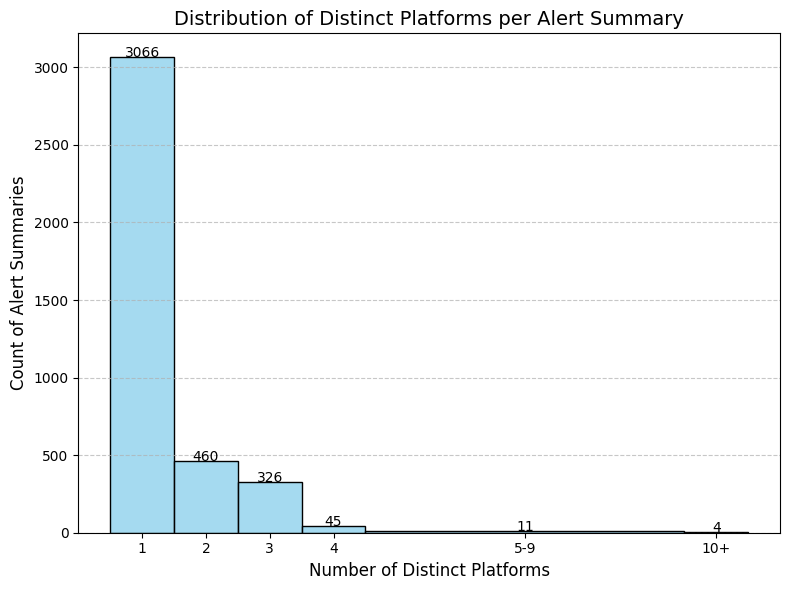

In [101]:
platform_counts = df.groupby('alert_summary_id')['single_alert_series_signature_machine_platform'].nunique()




platform_counts_binned = platform_counts.copy()
platform_counts_binned[platform_counts_binned.between(5, 9)] = 5  # Group 5-9
platform_counts_binned[platform_counts_binned >= 10] = 10         # Group 10+

# Manually define equal-width bins
bins = [1, 2, 3, 4, 5, 6]  # Define 5 bins for 1, 2, 3, 4, 5-9, 10+
bin_labels = ['1', '2', '3', '4', '5-9', '10+']

# Create the histogram
plt.figure(figsize=(8, 6))
hist_data = sns.histplot(
    platform_counts_binned, bins=[1, 2, 3, 4, 5, 10, 11], kde=False,
    color='skyblue', edgecolor='black'
)

# Set x-axis ticks and labels to match bins
plt.xticks(
    ticks=[1.5, 2.5, 3.5, 4.5, 7.5, 10.5],  # Center ticks for each bin
    labels=bin_labels  # Use custom labels for the bins
)

# Optional: Add labels on top of bars for clarity
for bar in hist_data.patches:
    count = int(bar.get_height())
    plt.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
        str(count), ha='center', fontsize=10
    )

# Add titles and labels
plt.title("Distribution of Distinct Platforms per Alert Summary", fontsize=14)
plt.xlabel("Number of Distinct Platforms", fontsize=12)
plt.ylabel("Count of Alert Summaries", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [102]:
grouped = df.groupby(["alert_summary_repository", "alert_status_general"]).size().reset_index(name="count")
table = grouped.pivot(index="alert_status_general", columns="alert_summary_repository", values="count").fillna(0)
table["Total"] = table.sum(axis=1)
table = table.astype(int)
display(table)

alert_summary_repository,autoland,firefox-android,mozilla-beta,mozilla-central,mozilla-release,Total
alert_status_general,,,,,,
FN,261,12,9,2,0,284
FP,703,20,123,0,0,846
SP,5323,1,1339,0,1,6664
TP,7306,763,2126,0,0,10195


In [103]:
grouped = df.groupby(["alert_summary_repository", "alert_status_general"]).size().reset_index(name="count")
table = grouped.pivot(index="alert_status_general", columns="alert_summary_repository", values="count").fillna(0)

# Combine FN and TP into a new row called "FN+TP"
table.loc["FN+TP"] = table.loc["FN"] + table.loc["TP"]

# Drop the original FN and TP rows
table = table.drop(index=["FN", "TP"])

# Add a Total column
table["Total"] = table.sum(axis=1)

# Convert values to integers
table = table.astype(int)

display(table)

alert_summary_repository,autoland,firefox-android,mozilla-beta,mozilla-central,mozilla-release,Total
alert_status_general,,,,,,
FP,703,20,123,0,0,846
SP,5323,1,1339,0,1,6664
FN+TP,7567,775,2135,2,0,10479


In [104]:
print(df['single_alert_noise_profile'].unique())

['OK' 'SKEWED' nan 'OUTLIERS' 'MODAL']


the noise profiles that exist are 'OK', 'SKEWED', 'N/A', 'OUTLIERS', and 'MODAL'. Their definitions from Mozilla code comments are:

- SKEWED: Samples are heavily found on one side of the mean.
- OUTLIERS: There are more outliers than should be expected from a normal distribution.
- MODAL: There are multiple areas where most values are found rather than only one.
- OK: No issues were found.
- N/A: Could not compute a noise profile.

In [105]:
grouped_framework = df.groupby('alert_summary_framework')['single_alert_series_signature_suite'].unique()
grouped_framework_df = grouped_framework.reset_index()
grouped_framework_df.rename(columns={'single_alert_series_signature_suite': 'Unique Signature Suites'}, inplace=True)
display(grouped_framework_df)

,alert_summary_framework,Unique Signature Suites
0,awsy,"[Base Content Resident Unique Memory, Base Content Heap Unclassified, Base Content JS, Base Content Explicit, Explicit Memory, Heap Unclassified, Images, Resident Memory, JS]"
1,browsertime,"[speedometer, speedometer3, motionmark-animometer-ramp, motionmark-htmlsuite-ramp, paypal, bing-search, fandom, google-search, outlook, microsoft, facebook, nytimes, reddit, linkedin, amazon, pinterest, netflix, espn, imdb, instagram, google-docs, ebay, wikia, cnn, yahoo-mail, wikipedia, office, google-slides, buzzfeed, youtube, expedia, imgur, bing, facebook-cristiano, sina, youtube-watch, cnn-ampstories, ebay-kleinanzeigen-search, google-search-restaurants, web-de, amazon-search, allrecipes, dailymail, booking, bing-search-restaurants, twitter, google-mail, tumblr, addkBLN, addkAR1, addkARN, addMbl1, addMblN, addMarN, addkBL1, addMabN, bild-de, motionmark-htmlsuite-1-3, motionmark-1-3, google-maps, twitch, webaudio, sunspider, stylebench, ares6, jetstream2, assorted-dom, motionmark-animometer, welcome, motionmark-htmlsuite, reddit-billgates-post-2.billg, reddit-billgates-post-2.hot, reddit-billgates-post-2.top, reddit-billgates-post-1.billg, reddit-billgates-post-1.comments, reddit-billgates-post-1.posts, reddit-billgates-ama.billg-ama, reddit-billgates-ama.members, cnn-nav.world, facebook-nav.friends, facebook-nav.groups, facebook-nav.landing, facebook-nav.marketplace, cnn-nav.landing, matrix-react-bench, microsoft-support, google, ebay-kleinanzeigen, stackoverflow, youtube-playback-h264-sfr, youtube-playback-av1-sfr]"
2,build_metrics,"[build times, compiler_metrics, installer size, sccache cache_write_errors, compiler warnings, sccache requests_not_cacheable, decision, apk-size-fenixDebug, apk-size-fenixNightly]"
3,devtools,"[damp, reload-webconsole:content-process, reload-inspector:parent-process, reload-inspector:content-process, browser-console:parent-process, reload-netmonitor:parent-process, reload-netmonitor:content-process, reload-debugger:parent-process, reload-debugger:content-process, server.pool, reload-no-devtools:content-process]"
4,mozperftest,"[test_caching.html, test_registration.html, AndroidStartup:fenix, AndroidStartup:geckoview_example]"
5,platform_microbench,"[BenchCollections, Strings, SegmenterPerf, TestIDNA, PermissionManagerTester, ImageDecodersPerf_JPG_Gray, ImageDecodersPerf_GIF_Rgb, Stylo, ImageDecodersPerf_PNG_Gray, ImageDecodersPerf_PNG_GrayAlpha, ImageDecodersPerf_PNG_Rgb, ImageDecodersPerf_PNG_RgbAlpha]"
6,talos,"[tp5o, tp5o_scroll, tsvgx, tsvgr_opacity, tscrollx, tsvg_static, tart, glvideo, sessionrestore_many_windows, perf_reftest, twinopen, sessionrestore, sessionrestore_no_auto_restore, cpstartup, pdfpaint, perf_reftest_singletons, about_preferences_basic, rasterflood_gradient, ts_paint, startup_about_home_paint, dromaeo_css, kraken, glterrain, motionmark_webgl, canvas2dvideo, offscreencanvas_webcodecs_main_webgl_h264, offscreencanvas_webcodecs_main_webgl_vp9, offscreencanvas_webcodecs_main_webgl_av1, offscreencanvas_webcodecs_worker_webgl_h264, offscreencanvas_webcodecs_worker_webgl_vp9, offscreencanvas_webcodecs_worker_webgl_av1, offscreencanvas_webcodecs_main_2d_h264, offscreencanvas_webcodecs_main_2d_vp9, offscreencanvas_webcodecs_main_2d_av1, offscreencanvas_webcodecs_worker_2d_h264, offscreencanvas_webcodecs_worker_2d_vp9, offscreencanvas_webcodecs_worker_2d_av1, basic_compositor_video, dromaeo_dom, tabswitch, startup_about_home_paint_realworld_webextensions, tabpaint, cross_origin_pageload, startup_about_home_paint_cached, displaylist_mutate, tresize, tp5n, a11yr, tp5o_webext, ts_paint_webext]"


In [106]:
grouped = df.groupby(["alert_summary_repository", "alert_summary_framework"]).size().reset_index(name="count")
table = grouped.pivot(index="alert_summary_framework", columns="alert_summary_repository", values="count").fillna(0)
table["Total"] = table.sum(axis=1)
table = table.astype(int)
display(table)

alert_summary_repository,autoland,firefox-android,mozilla-beta,mozilla-central,mozilla-release,Total
alert_summary_framework,,,,,,
awsy,108,0,86,0,0,194
browsertime,7543,760,1521,0,0,9824
build_metrics,458,36,124,0,1,619
devtools,2429,0,1281,0,0,3710
mozperftest,4,0,0,2,0,6
platform_microbench,1914,0,259,0,0,2173
talos,1137,0,326,0,0,1463


In [107]:
df_bugs = pd.read_csv('/content/bugs_data_from_api.csv', index_col=False)
display(df_bugs.head(5))

,id,type,summary,status,priority,severity,creator,assigned_to,creation_time,last_change_time,component,product,resolution,is_confirmed,platform,op_sys,assigned_to_name,assigned_to_email,cc,cc_detail,flags,classification,triage_owner,comment_count,keywords,depends_on,blocks,duplicates,creator_name,creator_email
0,1845251,defect,0.28 - 0.28% Base Content JS / Base Content JS (Windows) regression on Fri July 21 2023,RESOLVED,--,--,bacasandrei@mozilla.com,nobody@mozilla.org,2023-07-25T08:41:05Z,2023-07-25T09:07:42Z,JavaScript Engine,Core,WONTFIX,True,Unspecified,Unspecified,Nobody; OK to take it and work on it,nobody@mozilla.org,andrebargull@googlemail.com,andrebargull@googlemail.com,NaN,Components,NaN,3,"perf, perf-alert, regression",NaN,NaN,NaN,Acasandrei Beatrice (needinfo me),bacasandrei@mozilla.com
1,1863688,defect,"if the built-in pdfViewer of firefox is placed over a canvas, the pdf content disappears if you apply css ""transform: translate"" to the pdfViewer (new in Firefox 120 developer) on Windows",VERIFIED,--,S3,j.schoenemeyer@feldmann-mg.com,gwatson@mozilla.com,2023-11-08T08:27:24Z,2023-12-06T08:09:28Z,Graphics: WebRender,Core,FIXED,True,Unspecified,Unspecified,Glenn Watson [:gw] | PTO until 1/6/25,gwatson@mozilla.com,"aglavic@mozilla.com, asoncutean@mozilla.com, btot@mozilla.com, cdenizet@mozilla.com, dsmith@mozilla.com, gwatson@mozilla.com, mayankleoboy1@gmail.com, mchiorean@mozilla.com, pasik@iki.fi, tnikkel@gmail.com","aglavic@mozilla.com, asoncutean@mozilla.com, btot@mozilla.com, cdenizet@mozilla.com, dsmith@mozilla.com, gwatson@mozilla.com, mayankleoboy1@gmail.com, mchiorean@mozilla.com, pasik@iki.fi, tnikkel@gmail.com",NaN,Components,NaN,18,regression,NaN,NaN,NaN,Jürgen Schoenemeyer,j.schoenemeyer@feldmann-mg.com
2,1886231,task,Fix batching of sub-pass clip masks,RESOLVED,--,--,gwatson@mozilla.com,gwatson@mozilla.com,2024-03-19T16:46:46Z,2024-03-28T07:29:40Z,Graphics: WebRender,Core,FIXED,True,Unspecified,Unspecified,Glenn Watson [:gw] | PTO until 1/6/25,gwatson@mozilla.com,"aesanu@mozilla.com, mayankleoboy1@gmail.com","aesanu@mozilla.com, mayankleoboy1@gmail.com",NaN,Components,NaN,5,perf-alert,NaN,NaN,NaN,Glenn Watson [:gw] | PTO until 1/6/25,gwatson@mozilla.com
3,1843229,defect,Silently crash on GetQuotaObjectForFile,RESOLVED,P2,S2,seriousbuggie@gmail.com,hsingh@mozilla.com,2023-07-13T05:00:32Z,2024-02-11T17:10:05Z,Storage: IndexedDB,Core,FIXED,True,Unspecified,Unspecified,Harveer Singh,hsingh@mozilla.com,"acornestean@mozilla.com, aionescu@mozilla.com, hsingh@mozilla.com, jan.varga@gmail.com, smaug@mozilla.com, VYV03354@nifty.ne.jp","acornestean@mozilla.com, aionescu@mozilla.com, hsingh@mozilla.com, jan.varga@gmail.com, smaug@mozilla.com, VYV03354@nifty.ne.jp",NaN,Components,NaN,32,perf-alert,NaN,NaN,1848810,NaN,seriousbuggie@gmail.com
4,1855530,defect,Timeout in dom/base/test/test_lock_orientation_with_pending_fullscreen.html in M-xorig,RESOLVED,P2,S3,bugzeeeeee@gmail.com,m_kato@ga2.so-net.ne.jp,2023-09-27T19:00:22Z,2024-05-19T02:30:05Z,Sandboxing,GeckoView Graveyard,FIXED,True,All,Android,Makoto Kato [:m_kato] (off until Jan 5),m_kato@ga2.so-net.ne.jp,"aesanu@mozilla.com, m_kato@ga2.so-net.ne.jp","aesanu@mozilla.com, m_kato@ga2.so-net.ne.jp",NaN,Graveyard,NaN,17,perf-alert,NaN,1855511,"1855527, 1855534, 1855865, 1855866",[:owlish] 🦉 PST,bugzeeeeee@gmail.com


In [108]:
df_bugs_extended = pd.merge(df, df_bugs, left_on='alert_summary_bug_number', right_on='id', how='inner')
filtered_cols = df_bugs.columns.tolist()
filtered_cols.append("alert_summary_id")
filtered_cols.append("alert_summary_repository")
df_bugs_extended = df_bugs_extended[filtered_cols]
df_bugs_extended = df_bugs_extended.drop_duplicates()

In [109]:
df_bugs_copy = df_bugs.copy()

# Replace '--' with 'Unknown' or 'Unmentioned' in the copy
df_bugs_copy = df_bugs_copy.replace("--", "Unknown")

# Count occurrences of each characteristic level
severity_counts = df_bugs_copy["severity"].value_counts().reset_index()
severity_counts.columns = ["Level", "# of Bugs"]

status_counts = df_bugs_copy["status"].value_counts().reset_index()
status_counts.columns = ["Level", "# of Bugs"]

# Generate LaTeX table
latex_table = r"""
\begin{table}[]
    \caption{Characteristics of the 482 performance bugs in the dataset}
    \label{tab:bug_characteristics}
    \centering
    \begin{tabular}{llr}
    \toprule
        \textbf{Characteristic} & \textbf{Level} & \textbf{\# of Bugs} \\
    \midrule
"""

# Add Bug Severity rows
latex_table += r"        \multirow{" + str(len(severity_counts)) + r"}{*}{Bug Severity} "
for i, row in severity_counts.iterrows():
    latex_table += f"& {row['Level']} & {row['# of Bugs']} \\\\\n"

latex_table += r"         \midrule" + "\n"

# Add Bug Status rows
latex_table += r"        \multirow{" + str(len(status_counts)) + r"}{*}{Bug Status} "
for i, row in status_counts.iterrows():
    latex_table += f"& {row['Level']} & {row['# of Bugs']} \\\\\n"

latex_table += r"""    \end{tabular}
\end{table}
"""

# Print LaTeX table
print(latex_table)


\begin{table}[]
    \caption{Characteristics of the 482 performance bugs in the dataset}
    \label{tab:bug_characteristics}
    \centering
    \begin{tabular}{llr}
    \toprule
        \textbf{Characteristic} & \textbf{Level} & \textbf{\# of Bugs} \\
    \midrule
        \multirow{4}{*}{Bug Severity} & Unknown & 265 \\
& S3 & 125 \\
& S4 & 33 \\
& S2 & 26 \\
         \midrule
        \multirow{5}{*}{Bug Status} & RESOLVED & 427 \\
& NEW & 35 \\
& VERIFIED & 16 \\
& ASSIGNED & 3 \\
& REOPENED & 1 \\
    \end{tabular}
\end{table}



In [110]:
print(df_bugs['status'].unique())

['RESOLVED' 'VERIFIED' 'NEW' 'ASSIGNED' 'REOPENED']


In [111]:
df_bugs["severity"] = df_bugs["severity"].fillna("Unknown")

# Replace '--' or missing values in 'status' with "Unknown" if applicable
df_bugs["status"] = df_bugs["status"].replace("--", "Unknown")

# Group by severity and status to count bugs
grouped = df_bugs.groupby(["severity", "status"]).size().reset_index(name="# of Bugs")

# Generate LaTeX table
latex_table = r"""
\begin{table}[]
    \caption{Characteristics of the 482 performance bugs in the dataset}
    \label{tab:bug_characteristics}
    \centering
    \begin{tabular}{llr}
    \toprule
        \textbf{Bug Severity} & \textbf{Bug Status} & \textbf{\# of Bugs} \\
    \midrule
"""

# Add rows to the LaTeX table with separating lines between severities
current_severity = None
for i, row in grouped.iterrows():
    if row["severity"] != current_severity:
        if current_severity is not None:  # Add separating line before a new severity
            latex_table += "        \\midrule\n"
        current_severity = row["severity"]
        latex_table += f"        \\multirow{{{len(grouped[grouped['severity'] == current_severity])}}}{{*}}{{{current_severity}}} "
    else:
        latex_table += " " * 8  # Indent for alignment
    latex_table += f"& {row['status']} & {row['# of Bugs']} \\\\\n"

latex_table += r"""    \end{tabular}
\end{table}
"""

# Print LaTeX table
print(latex_table)


\begin{table}[]
    \caption{Characteristics of the 482 performance bugs in the dataset}
    \label{tab:bug_characteristics}
    \centering
    \begin{tabular}{llr}
    \toprule
        \textbf{Bug Severity} & \textbf{Bug Status} & \textbf{\# of Bugs} \\
    \midrule
        \multirow{4}{*}{--} & NEW & 4 \\
        & REOPENED & 1 \\
        & RESOLVED & 255 \\
        & VERIFIED & 5 \\
        \midrule
        \multirow{2}{*}{S2} & RESOLVED & 22 \\
        & VERIFIED & 4 \\
        \midrule
        \multirow{4}{*}{S3} & ASSIGNED & 1 \\
        & NEW & 21 \\
        & RESOLVED & 97 \\
        & VERIFIED & 6 \\
        \midrule
        \multirow{3}{*}{S4} & ASSIGNED & 2 \\
        & NEW & 9 \\
        & RESOLVED & 22 \\
        \midrule
        \multirow{3}{*}{Unknown} & NEW & 1 \\
        & RESOLVED & 31 \\
        & VERIFIED & 1 \\
    \end{tabular}
\end{table}



In [112]:
print("Percentage of alert summaries with bugs: " + str((df_bugs_extended.shape[0] / df['alert_summary_id'].nunique()) * 100) + " %")

Percentage of alert summaries with bugs: 16.180981595092025 %


In [113]:
df_bugs_filtered = df_bugs_extended.drop('alert_summary_id', axis=1)
df_bugs_filtered = df_bugs_filtered.drop_duplicates()
print(df_bugs_filtered.shape[0])

491


In [114]:
grouped = df_bugs_filtered.groupby(["alert_summary_repository", "product"]).size().reset_index(name="count")
table = grouped.pivot(index="product", columns="alert_summary_repository", values="count").fillna(0)
table["Total By Product"] = table.sum(axis=1)
table = table.astype(int)
table = table.rename(columns=lambda x: x.replace("_", " ").title())
table = table.rename(columns={
    "Alert Summary Repository": "Alert Summary Repository",
    "Firefox-Android": "Firefox Android",
                              "autoland": "Autoland",
                              "mozilla-beta": "Mozilla Beta",
                              "mozilla-central": "Mozilla Central",
                              "mozilla-release": "Mozilla Release"})
table.loc["Total By Repository"] = table.sum(axis=0)
display(table)
table.index = table.index.str.replace("-", " ").str.title()
latex_table = table.to_latex(
    index=True,
    caption="Bugs distribution per product for all repositories",
    label="tab:bugs_per_product_per_repository",
    escape=False
)
latex_table = latex_table.replace(
    r"\begin{tabular}",
    r"\resizebox{\columnwidth}{!}{\begin{tabular}"
).replace(
    r"\end{tabular}",
    r"\end{tabular}}"
)
print(latex_table)

alert_summary_repository,Autoland,Firefox Android,Mozilla-Beta,Mozilla-Central,Mozilla-Release,Total By Product
product,,,,,,
Core,268,3,7,0,0,278
DevTools,49,0,0,0,0,49
Fenix,0,12,0,1,0,13
Firefox,36,1,2,0,0,39
Firefox Build System,26,0,0,1,1,28
GeckoView,2,2,0,0,0,4
GeckoView Graveyard,1,0,0,0,0,1
Release Engineering,2,0,1,0,0,3
Remote Protocol,2,0,0,0,0,2


\begin{table}
\caption{Bugs distribution per product for all repositories}
\label{tab:bugs_per_product_per_repository}
\resizebox{\columnwidth}{!}{\begin{tabular}{lrrrrrr}
\toprule
alert_summary_repository & Autoland & Firefox Android & Mozilla-Beta & Mozilla-Central & Mozilla-Release & Total By Product \\
product &  &  &  &  &  &  \\
\midrule
Core & 268 & 3 & 7 & 0 & 0 & 278 \\
Devtools & 49 & 0 & 0 & 0 & 0 & 49 \\
Fenix & 0 & 12 & 0 & 1 & 0 & 13 \\
Firefox & 36 & 1 & 2 & 0 & 0 & 39 \\
Firefox Build System & 26 & 0 & 0 & 1 & 1 & 28 \\
Geckoview & 2 & 2 & 0 & 0 & 0 & 4 \\
Geckoview Graveyard & 1 & 0 & 0 & 0 & 0 & 1 \\
Release Engineering & 2 & 0 & 1 & 0 & 0 & 3 \\
Remote Protocol & 2 & 0 & 0 & 0 & 0 & 2 \\
Testing & 41 & 6 & 14 & 0 & 0 & 61 \\
Toolkit & 9 & 1 & 0 & 0 & 0 & 10 \\
Web Compatibility & 2 & 0 & 1 & 0 & 0 & 3 \\
Total By Repository & 438 & 25 & 25 & 2 & 1 & 491 \\
\bottomrule
\end{tabular}}
\end{table}



In [115]:
# Create a new column that fills NaN values in 'single_alert_series_signature_test' with 'single_alert_series_signature_suite'
df["test_or_suite"] = df["single_alert_series_signature_test"].fillna(
    df["single_alert_series_signature_suite"]
)

# Grouping and aggregating counts
framework_stats = (
    df.groupby("alert_summary_framework")
    .agg(
        test_suite_count=("single_alert_series_signature_suite", "nunique"),  # Unique test suites
        test_count=("test_or_suite", "nunique"),  # Unique tests or suites
    )
    .reset_index()
)

# Adding the total row
total_row = pd.DataFrame({
    "alert_summary_framework": ["Total"],
    "test_suite_count": [framework_stats["test_suite_count"].sum()],
    "test_count": [framework_stats["test_count"].sum()],
})

framework_stats_with_total = pd.concat([framework_stats, total_row], ignore_index=True)

display(framework_stats_with_total)
# Converting to LaTeX table
latex_table = framework_stats_with_total.rename(
    columns={
        "alert_summary_framework": "Framework",
        "test_suite_count": "Test Suite Count",
        "test_count": "Test Count",
    }
).to_latex(
    index=False,
    caption="Test Suite and Tests count per framework",
    label="tab:test_suite_test_per_framework",
)

print(latex_table)


,alert_summary_framework,test_suite_count,test_count
0,awsy,9,9
1,browsertime,91,33
2,build_metrics,9,12
3,devtools,11,131
4,mozperftest,4,4
5,platform_microbench,12,168
6,talos,50,170
7,Total,186,527


\begin{table}
\caption{Test Suite and Tests count per framework}
\label{tab:test_suite_test_per_framework}
\begin{tabular}{lrr}
\toprule
Framework & Test Suite Count & Test Count \\
\midrule
awsy & 9 & 9 \\
browsertime & 91 & 33 \\
build_metrics & 9 & 12 \\
devtools & 11 & 131 \\
mozperftest & 4 & 4 \\
platform_microbench & 12 & 168 \\
talos & 50 & 170 \\
Total & 186 & 527 \\
\bottomrule
\end{tabular}
\end{table}

